In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import matplotlib.pyplot as plt
import numpy as np

import torch

from transformers import GPT2Tokenizer, GPT2LMHeadModel

from transformer_geometrical_analysis.utils.retrieval import get_activations, extract_weights


In [2]:
gpt2_version = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(gpt2_version)
model = GPT2LMHeadModel.from_pretrained(gpt2_version, output_hidden_states=True, return_dict_in_generate=True)

In [3]:
# constants of the model
TOTAL_VOCAB_SIZE = tokenizer.vocab_size
MAXIMUM_INPUT_LENGTH = 1024
N_BLOCKS = 12

TOTAL_VOCAB_SIZE

50257

In [4]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
with open("input_phrases copy.txt", "r") as f:
    prompts = [line.strip() for line in f if line.strip()]

print(len(model.transformer.h))

12


In [6]:
from collections import defaultdict

In [7]:
# register hooks once: initialization
activations = get_activations(model)
num_blocks = len(model.transformer.h)
d = model.config.hidden_size
# generating random prompts of a fixed token size
n_tokens = 100
n_prompts = 100
prompts = [torch.randint(0, TOTAL_VOCAB_SIZE, size = (1, n_tokens)) for _ in range(n_prompts)]
# registering the hooks and initializing the dict to store all activations
activations = get_activations(model)
# runnning all the prompts to obtain all activations
for prompt in prompts:
    with torch.no_grad():
        _ = model(prompt)
# extracting all the weights from the transformer
weights = extract_weights(model)

#####

BLOCK 0

#####

------------------------------

attn.c_attn.q shape: (768, 768) 

buffer shape: (100, 100, 768)

cov mat shape: (768, 768) 
 eig vecs shape: (768, 768)

max rank: 768

# overlaps: (768,)
  attn.c_attn.q: 5.34% above ν+ = 13.23, 0.00% below ν− = 0.00


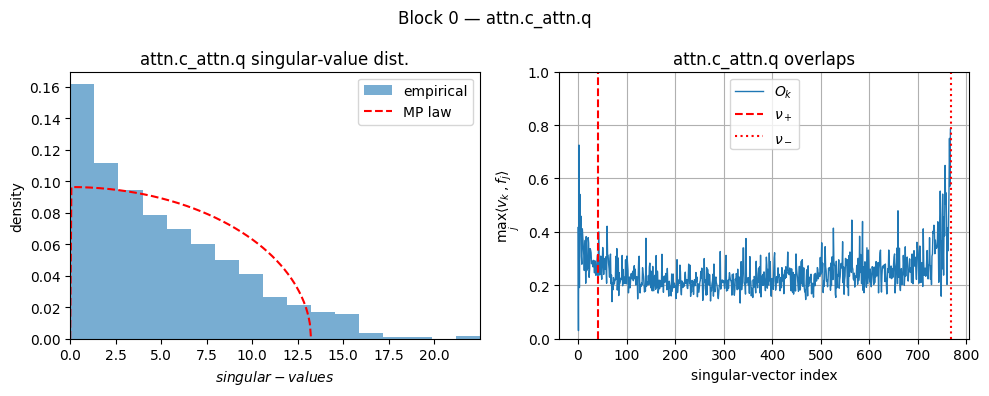

------------------------------

attn.c_attn.k shape: (768, 768) 

buffer shape: (100, 100, 768)

cov mat shape: (768, 768) 
 eig vecs shape: (768, 768)

max rank: 768

# overlaps: (768,)
  attn.c_attn.k: 5.99% above ν+ = 13.48, 0.00% below ν− = 0.00


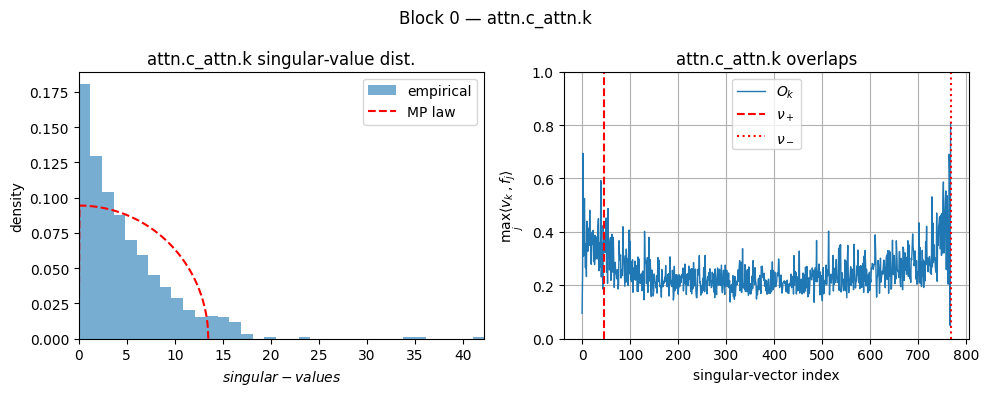

------------------------------

attn.c_attn.v shape: (768, 768) 

buffer shape: (100, 100, 768)

cov mat shape: (768, 768) 
 eig vecs shape: (768, 768)

max rank: 768

# overlaps: (768,)
  attn.c_attn.v: 3.52% above ν+ = 3.22, 0.00% below ν− = 0.00


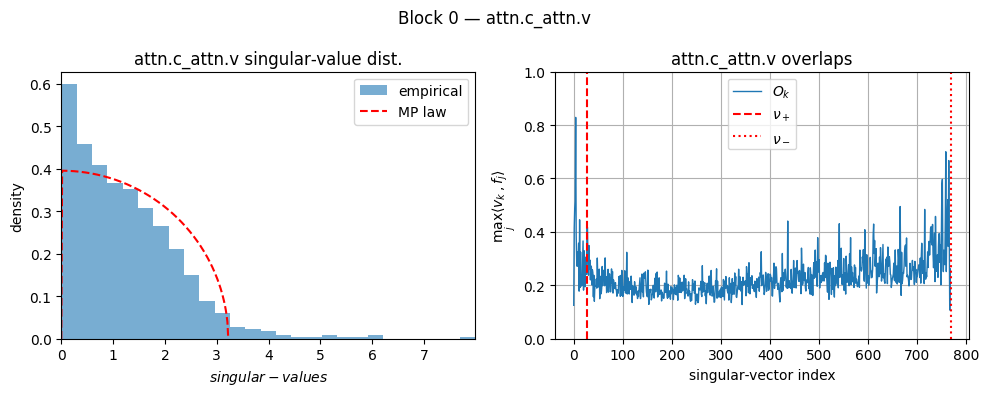

------------------------------

attn.c_proj shape: (768, 768) 

buffer shape: (100, 100, 768)

cov mat shape: (768, 768) 
 eig vecs shape: (768, 768)

max rank: 768

# overlaps: (768,)
  attn.c_proj: 5.99% above ν+ = 8.17, 0.00% below ν− = 0.00


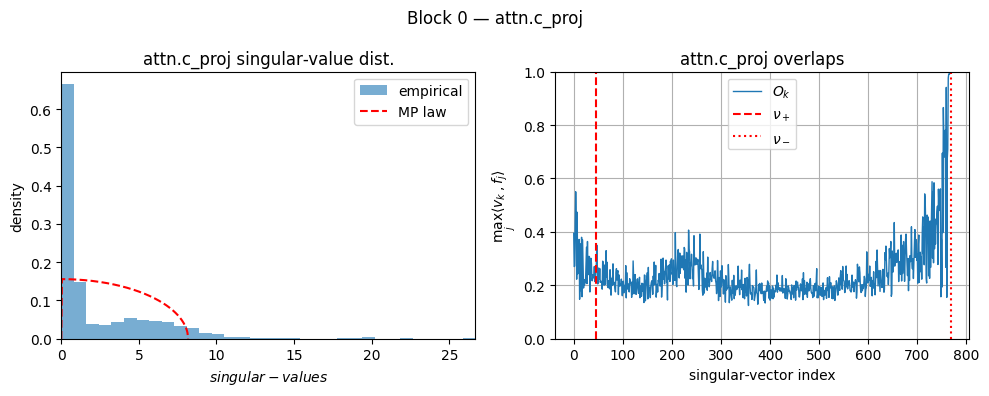

------------------------------

mlp.c_fc shape: (768, 3072) 

buffer shape: (100, 100, 3072)

cov mat shape: (3072, 3072) 
 eig vecs shape: (3072, 3072)

max rank: 768

# overlaps: (768,)
  mlp.c_fc: 6.12% above ν+ = 11.74, 14.58% below ν− = 3.91


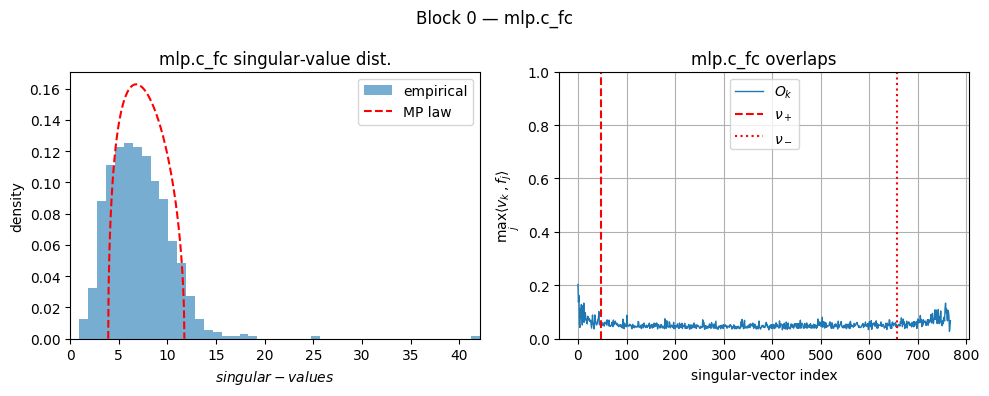

------------------------------

mlp.c_proj shape: (3072, 768) 

buffer shape: (100, 100, 768)

cov mat shape: (768, 768) 
 eig vecs shape: (768, 768)

max rank: 768

# overlaps: (768,)
  mlp.c_proj: 63.41% above ν+ = 3.66, 0.13% below ν− = 1.22


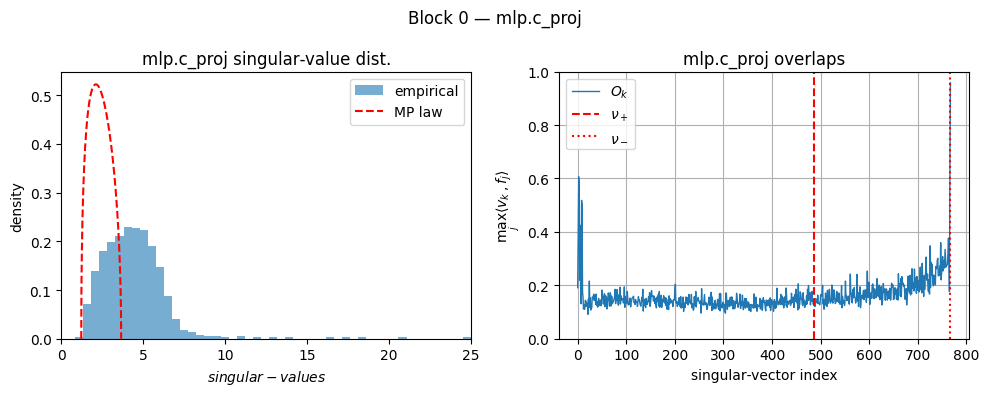

In [8]:
eps = 1e-8

for block_idx in range(1): #(N_BLOCKS):

    print("#####\n")
    print(f"BLOCK {block_idx}\n")
    print("#####\n")

    def slice_acts(key):
        """
        Function that returns all entries in `activations[key]` that correspond to the current `block_idx`
        """
        acts = activations[key]
        current_block_acts = []
        for i in range(n_prompts):
            selected_act = acts[i * N_BLOCKS + block_idx]
            n, d = selected_act.shape
            current_block_acts.append(selected_act.reshape(1,n,d))
        return torch.cat(current_block_acts, dim=0)
    

    # dict containing all weights and activations for each sublayer of the current `block_idx`
    sublayers = {
        sublayer: {"W": weights[f"h.{block_idx}.{sublayer}.weight"],"X": slice_acts(sublayer)} for sublayer in activations.keys()
    }

    # performs the decomposition and analysis of only the layers specified
    sublayer_selection = [
        "attn.c_attn.q",
        "attn.c_attn.k",
        "attn.c_attn.v",
        "attn.c_proj",
        "mlp.c_fc",
        "mlp.c_proj"
    ]

    for name, info in sublayers.items():
        if name not in sublayer_selection: continue
        
        # --- extract W and flattened X ---
        W = info["W"].cpu().numpy() # (m,n)
        X = info["X"].cpu().numpy() # buffers 
        # shape = (P, L, n), P: # prompts, L: # tokens, n: # dimensions
        P, L, n = X.shape
        N = P * L   # N: # configs per dim
        X_flat = X.reshape(N, n)

        print("------------------------------\n")
        print(      name, "shape:", W.shape, "\n")
        print(      "buffer shape:", X.shape)

        # --- activation covariance in input space ---
        Xc = X_flat - X_flat.mean(axis=0, keepdims=True)
        F = (Xc.T @ Xc) / N     # activation covariance matrix size: (n, n)
        evals, evecs = np.linalg.eigh(F)
        idx = np.argsort(evals)[::-1]
        f_vals, f_vecs = evals[idx], evecs[:, idx]
        print( "\ncov mat shape:", F.shape, "\n", "eig vecs shape:", f_vecs.shape)

        # --- SVD of W ---
        U, svals, Vt = np.linalg.svd(W, full_matrices=False)   # svals.shape=(r,), Vt=(r,n)
        max_rank = np.min(W.shape)
        print("\nmax rank:", max_rank)

        # removing all eigenvalues we are sure to be 0
        w_svals = svals[:max_rank]
        w_rvecs = Vt[:,:max_rank]

        # and the corresponding eigenvectors in the act_cov
        f_vals = f_vals[:max_rank]
        f_vecs = f_vecs[:max_rank,:max_rank]

        # --- overlap --- Vt (r,n) @ f_vecs (n, n)
        overlaps = np.max(w_rvecs @ f_vecs, axis=1)   # O_k
        print("\n# overlaps:", overlaps.shape)

        # --- MP bounds ---
        m, n = W.shape
        c = min(m,n)/max(m,n)
        #c = m / n
        sigma = np.std(W)*np.sqrt(n)
        lam_min = sigma*(1 - np.sqrt(c))
        lam_min = np.where(lam_min < 0, 0, lam_min)
        lam_max = sigma*(1 + np.sqrt(c))

        # --- report fraction of outliers ---
        s_desc = np.sort(w_svals)[::-1]
        frac_hi = np.sum(s_desc > lam_max) / s_desc.shape[0]
        frac_lo = np.sum(s_desc < lam_min) / s_desc.shape[0]
        print(f"  {name}: {100*frac_hi:.2f}% above ν+ = {lam_max:.2f}, {100*frac_lo:.2f}% below ν− = {lam_min:.2f}")

        # --- MP‐PDF (clamp lower edge to eps) ---
        lam0 = max(lam_min, eps)
        lam_grid = np.linspace(lam0, lam_max, 200)
        pdf = (1/(np.pi * sigma**2 * c)) \
              * np.sqrt((lam_max**2 - lam_grid**2)*(lam_grid**2 - lam0**2)) \
              / (lam_grid)

        # --- find index‐boundaries ν+, ν- ---
        nu_plus  = (s_desc > lam_max).sum()
        nu_minus = (s_desc < lam_min).sum()

        # --- plotting ---
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
        # histogram + MP
        ax1.hist(w_svals, bins="fd", density=True, alpha=0.6, label='empirical')
        ax1.plot(lam_grid, pdf, 'r--', label='MP law')
        ax1.set_xlim(0, np.quantile(w_svals, 1))
        ax1.set_title(f"{name} singular‐value dist.")
        ax1.set_xlabel(r"$singular-values$")
        ax1.set_ylabel("density")
        ax1.legend()

        # overlap + vertical ν lines
        ax2.plot(overlaps, lw=1, label=r"$O_k$")
        ax2.axvline(nu_plus,  color='r', ls='--', label=r'$\nu_+$')
        ax2.axvline(max_rank - nu_minus, color='r', ls=':', label=r'$\nu_-$')
        ax2.set_ylim(0,1)
        ax2.set_title(f"{name} overlaps")
        ax2.set_xlabel("singular‐vector index")
        ax2.set_ylabel(r"$\max_j\langle v_k,f_j\rangle$")
        ax2.legend()
        ax2.grid(True)

        plt.suptitle(f"Block {block_idx} — {name}")
        plt.tight_layout()
        plt.show()


=== Block 0 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [26.68571  21.945415 20.072739 19.553143 19.267342]
      MP bounds: [0.000, 8.173]
      top 5 overlaps: [0.2364772  0.37498899 0.28395305 0.16077615 0.160035  ]

      fraction svals~0: 0.125 | # of singular values λ: 768


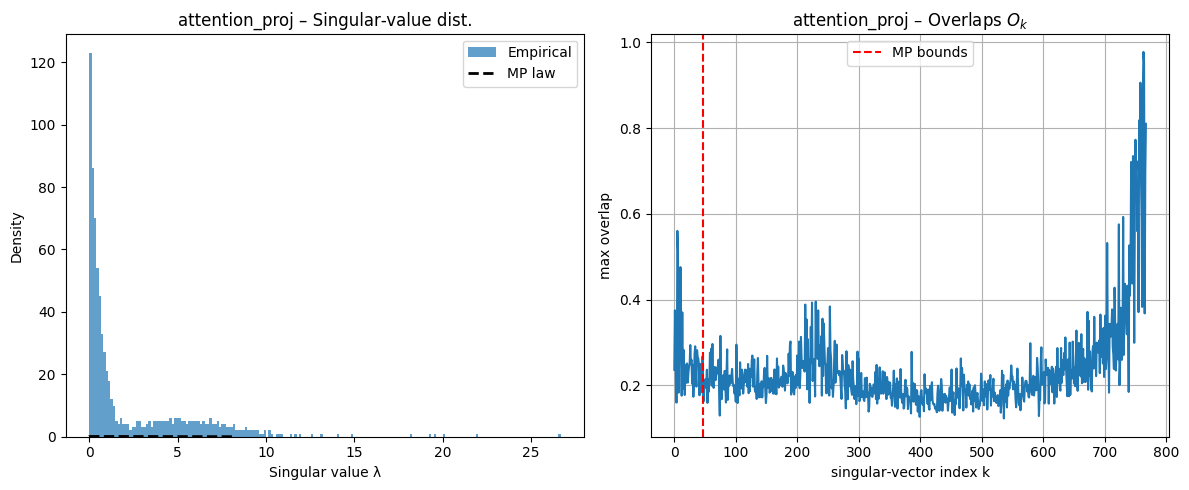

      mlp_up_proj     | W.shape=(768, 3072),  X.shape=(2454, 3072)
      top 5 σ(W): [42.10523  25.104057 19.003927 17.515568 17.437208]
      MP bounds: [3.912, 11.737]
      top 5 overlaps: [0.21710336 0.20443828 0.32273575 0.28725096 0.14236663]

      fraction svals~0: 0.000 | # of singular values λ: 768


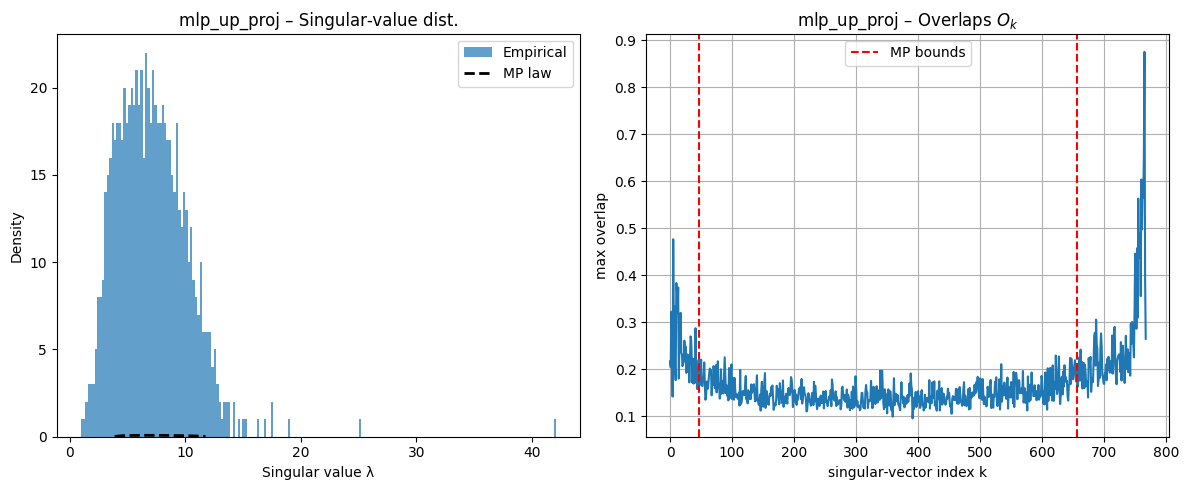

      mlp_down_proj   | W.shape=(3072, 768),  X.shape=(2454, 768)
      top 5 σ(W): [25.033083 21.053623 18.337223 17.38064  16.256277]
      MP bounds: [0.000, 7.313]
      top 5 overlaps: [0.17189393 0.16021993 0.157372   0.23074922 0.24963335]

      fraction svals~0: 0.000 | # of singular values λ: 768


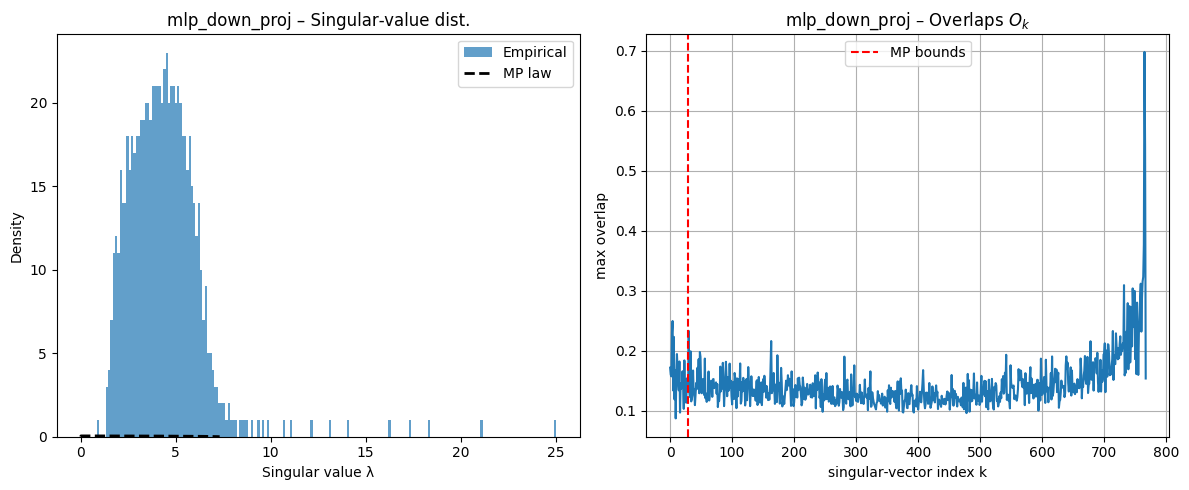


=== Block 1 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [26.942665  18.28963   17.114307  14.3792095 14.045343 ]
      MP bounds: [0.000, 5.649]
      top 5 overlaps: [0.70224636 0.38372586 0.41945436 0.16162262 0.2190531 ]

      fraction svals~0: 0.062 | # of singular values λ: 768


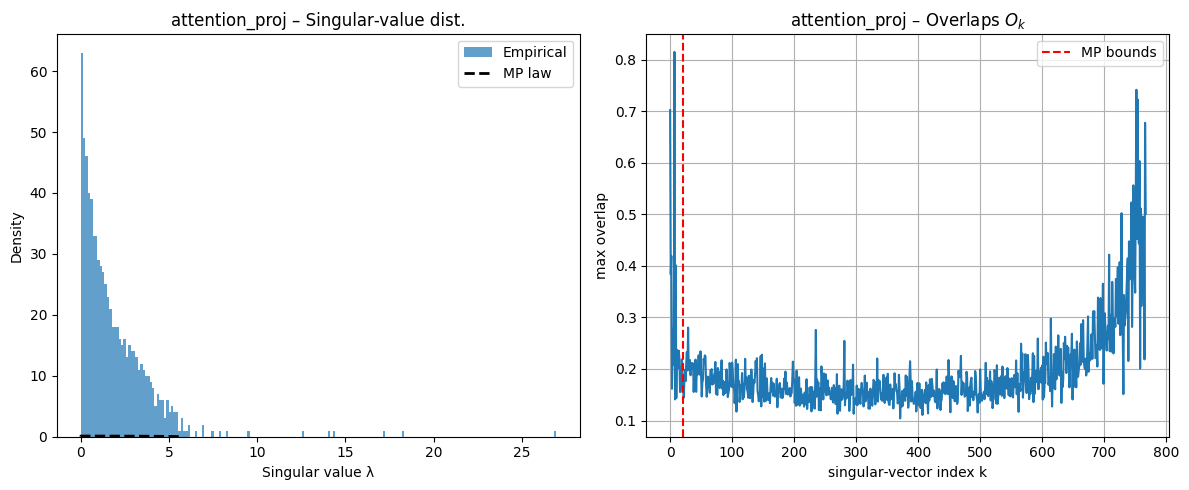

      mlp_up_proj     | W.shape=(768, 3072),  X.shape=(2454, 3072)
      top 5 σ(W): [38.6397   27.224878 20.861197 18.683702 18.155819]
      MP bounds: [3.623, 10.868]
      top 5 overlaps: [0.32500534 0.52427085 0.22761193 0.17682972 0.49024341]

      fraction svals~0: 0.000 | # of singular values λ: 768


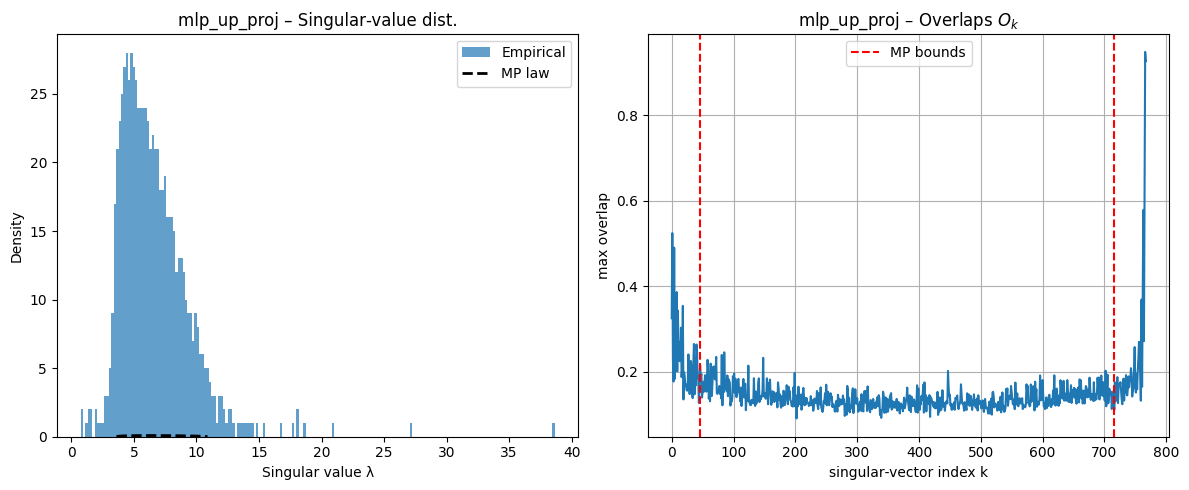

      mlp_down_proj   | W.shape=(3072, 768),  X.shape=(2454, 768)
      top 5 σ(W): [28.70648  23.103569 18.841396 13.833972 13.739472]
      MP bounds: [0.000, 7.249]
      top 5 overlaps: [0.81936153 0.90337417 0.29762922 0.14923004 0.28572261]

      fraction svals~0: 0.000 | # of singular values λ: 768


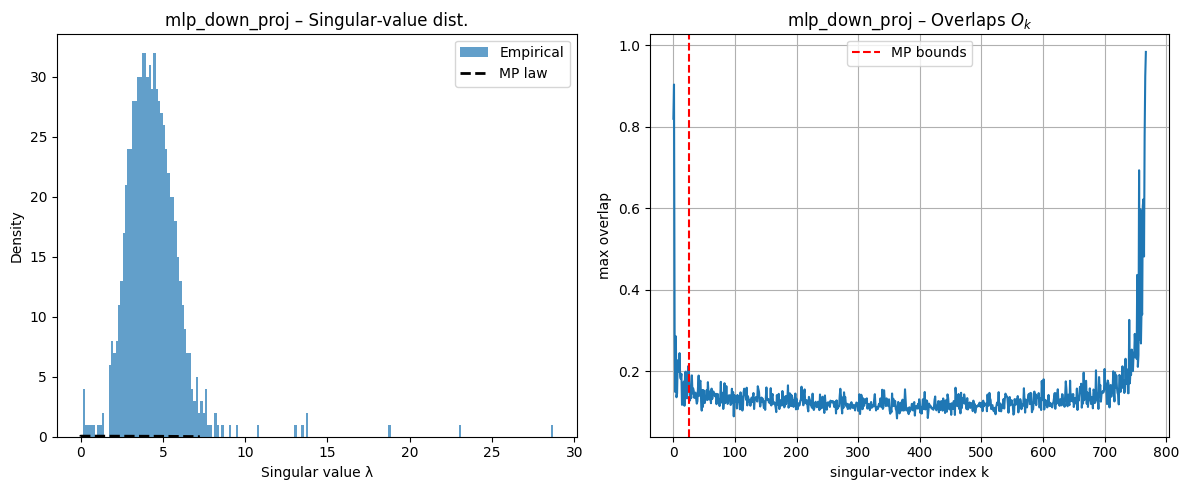


=== Block 2 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [13.932549   8.446818   8.018706   7.668459   7.0211883]
      MP bounds: [0.000, 4.491]
      top 5 overlaps: [0.25146381 0.18552494 0.15027335 0.15852756 0.12196442]

      fraction svals~0: 0.060 | # of singular values λ: 768


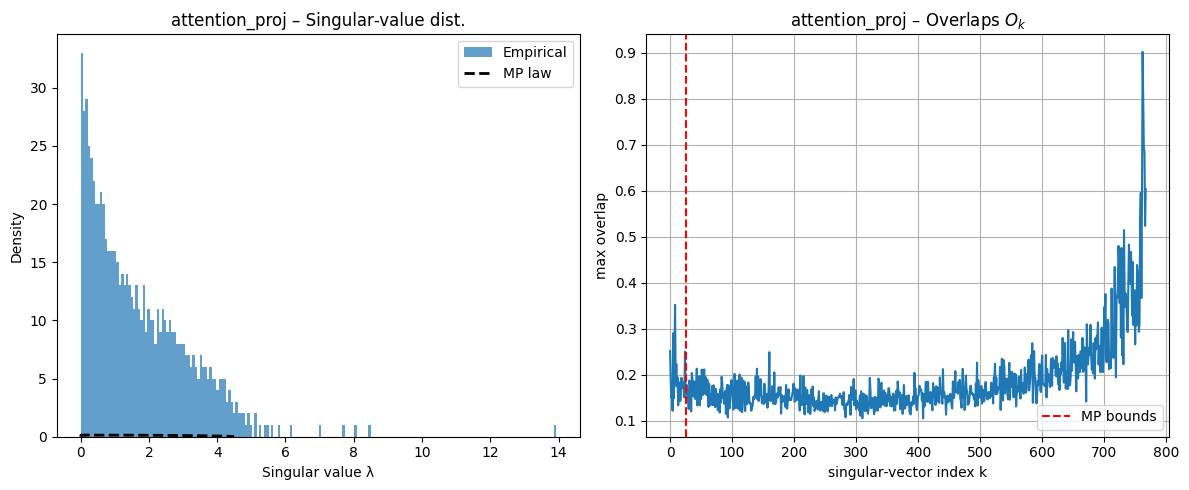

      mlp_up_proj     | W.shape=(768, 3072),  X.shape=(2454, 3072)
      top 5 σ(W): [38.75123  32.40382  22.221004 20.78508  19.965721]
      MP bounds: [3.700, 11.101]
      top 5 overlaps: [0.24882847 0.20620661 0.20742641 0.32965814 0.18974947]

      fraction svals~0: 0.000 | # of singular values λ: 768


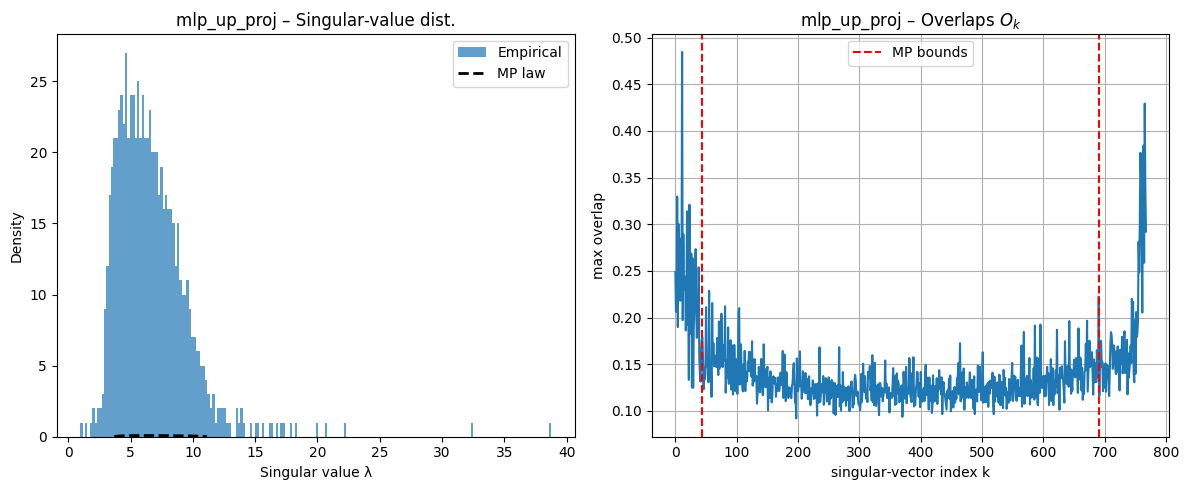

      mlp_down_proj   | W.shape=(3072, 768),  X.shape=(2454, 768)
      top 5 σ(W): [38.254498 15.164708 13.083903 12.103218 11.579123]
      MP bounds: [0.000, 7.739]
      top 5 overlaps: [0.98510556 0.1748634  0.51537478 0.41990045 0.27650926]

      fraction svals~0: 0.000 | # of singular values λ: 768


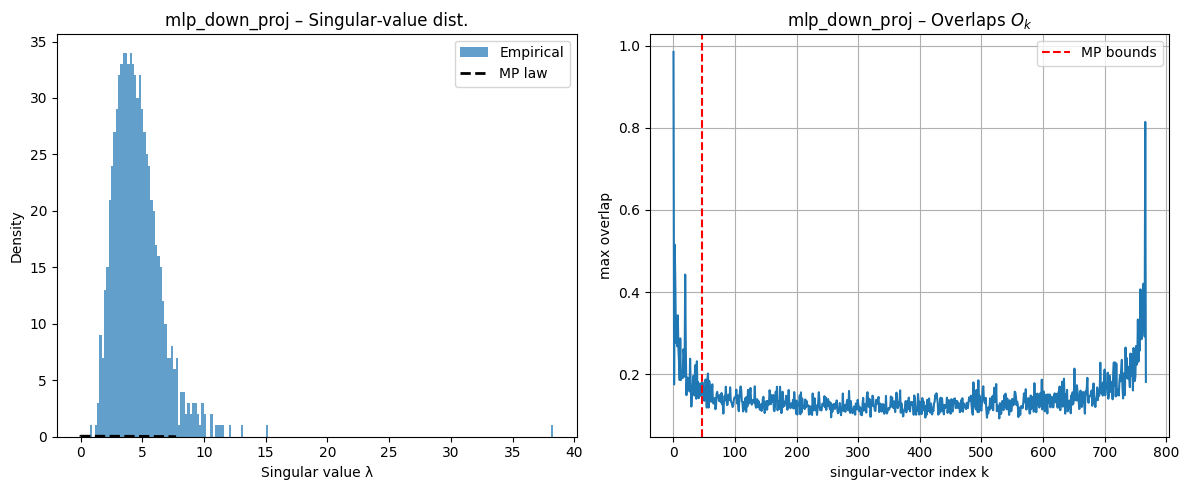


=== Block 3 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [12.972315   6.5814233  6.4028716  6.304977   6.0279493]
      MP bounds: [0.000, 4.663]
      top 5 overlaps: [0.19090845 0.28385457 0.25682917 0.3748617  0.22863111]

      fraction svals~0: 0.055 | # of singular values λ: 768


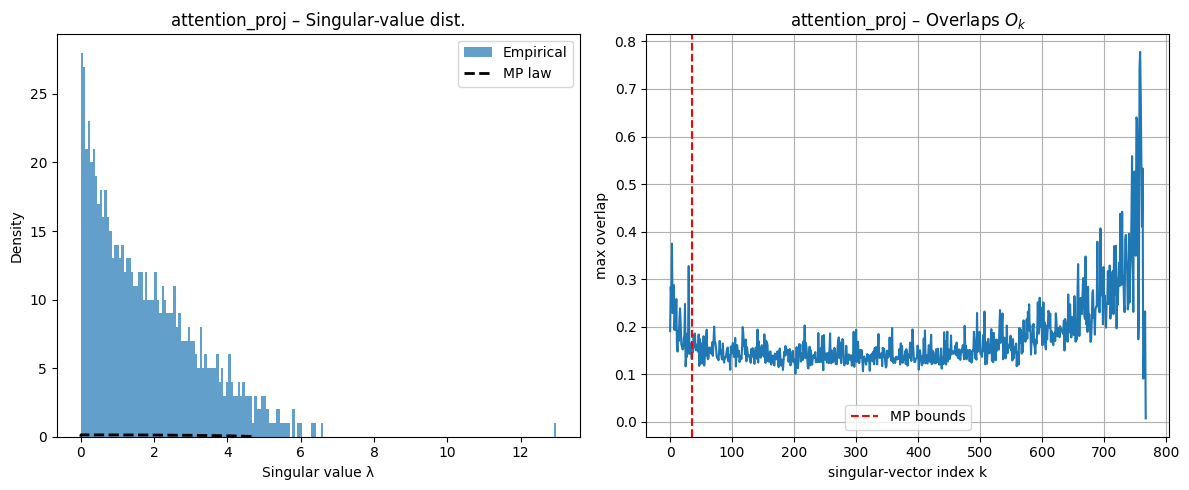

      mlp_up_proj     | W.shape=(768, 3072),  X.shape=(2454, 3072)
      top 5 σ(W): [32.490036 18.568136 17.984472 17.807253 17.184204]
      MP bounds: [3.590, 10.769]
      top 5 overlaps: [0.16435947 0.53926824 0.43151727 0.32655426 0.2702779 ]

      fraction svals~0: 0.000 | # of singular values λ: 768


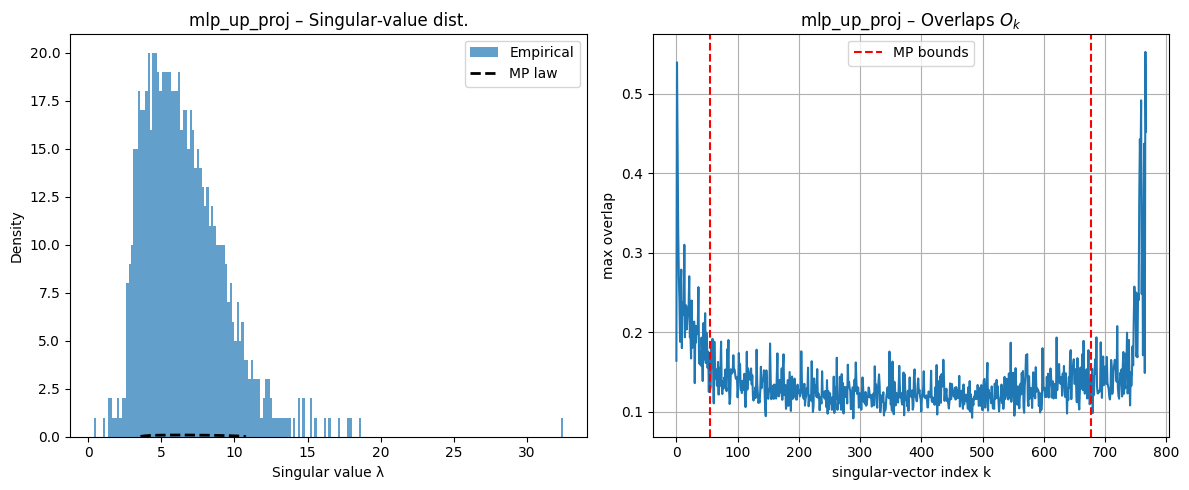

      mlp_down_proj   | W.shape=(3072, 768),  X.shape=(2454, 768)
      top 5 σ(W): [40.800926 13.37185  12.183411 11.731571 11.369176]
      MP bounds: [0.000, 7.633]
      top 5 overlaps: [0.92069795 0.28323303 0.26128794 0.34062281 0.17965096]

      fraction svals~0: 0.000 | # of singular values λ: 768


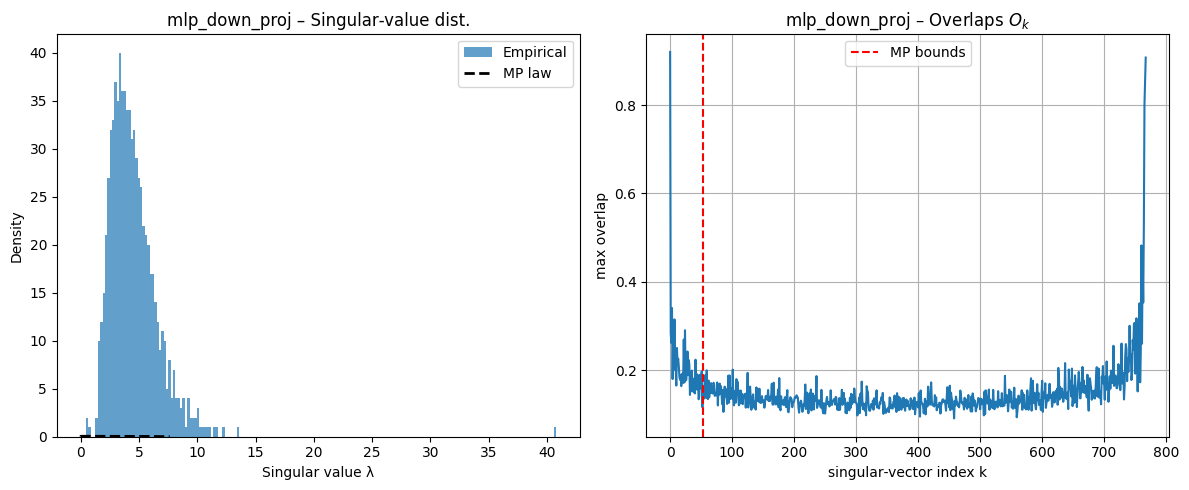


=== Block 4 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [14.514586   7.6902137  7.2251496  6.8359456  6.733054 ]
      MP bounds: [0.000, 5.153]
      top 5 overlaps: [0.12624975 0.19166888 0.32103317 0.25881483 0.1771565 ]

      fraction svals~0: 0.069 | # of singular values λ: 768


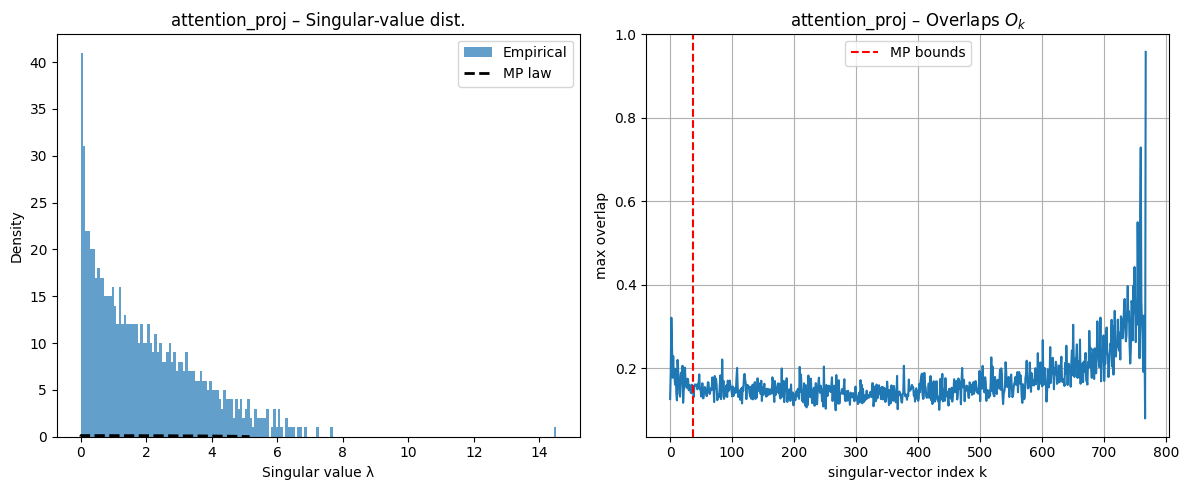

      mlp_up_proj     | W.shape=(768, 3072),  X.shape=(2454, 3072)
      top 5 σ(W): [31.798595 20.03591  19.59754  18.404066 17.365112]
      MP bounds: [3.595, 10.784]
      top 5 overlaps: [0.14933717 0.30133929 0.23775766 0.44340334 0.49272659]

      fraction svals~0: 0.000 | # of singular values λ: 768


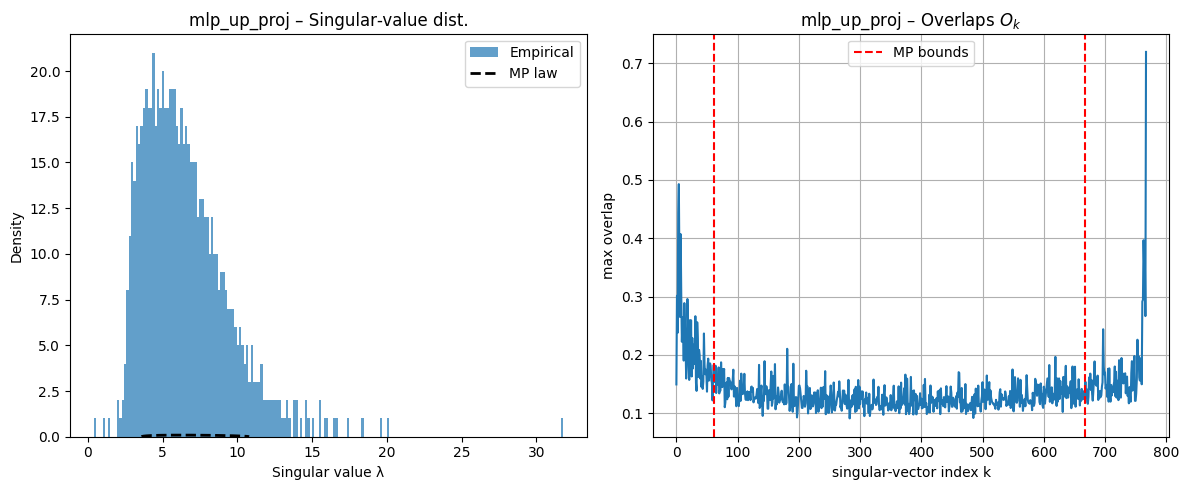

      mlp_down_proj   | W.shape=(3072, 768),  X.shape=(2454, 768)
      top 5 σ(W): [31.635202  14.195633  13.1287365 12.495579  11.97119  ]
      MP bounds: [0.000, 7.566]
      top 5 overlaps: [0.95292681 0.33168221 0.25419535 0.31952504 0.28470632]

      fraction svals~0: 0.000 | # of singular values λ: 768


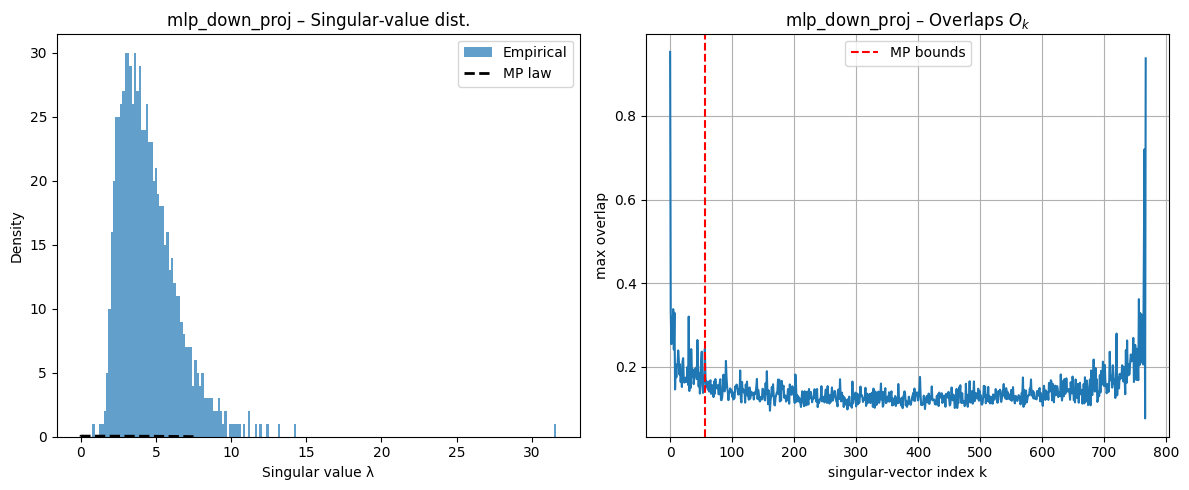


=== Block 5 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [12.8471575  8.734663   6.9979553  6.8258266  6.7345657]
      MP bounds: [0.000, 5.198]
      top 5 overlaps: [0.35039861 0.29402726 0.26401419 0.32633324 0.20915548]

      fraction svals~0: 0.046 | # of singular values λ: 768


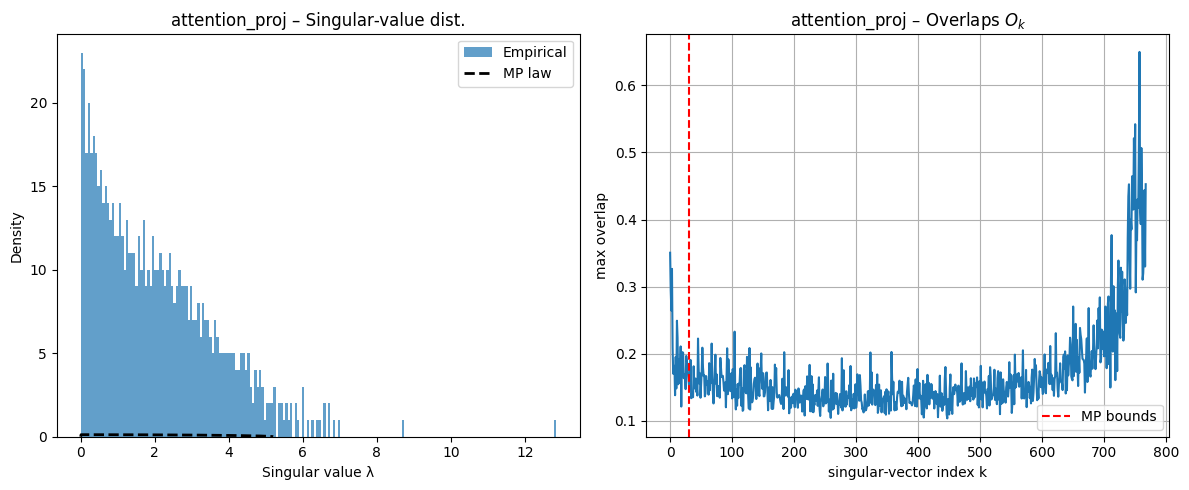

      mlp_up_proj     | W.shape=(768, 3072),  X.shape=(2454, 3072)
      top 5 σ(W): [32.34236  19.454994 17.655796 16.909075 16.049355]
      MP bounds: [3.511, 10.534]
      top 5 overlaps: [0.29930001 0.35710089 0.39054063 0.26617329 0.39006889]

      fraction svals~0: 0.000 | # of singular values λ: 768


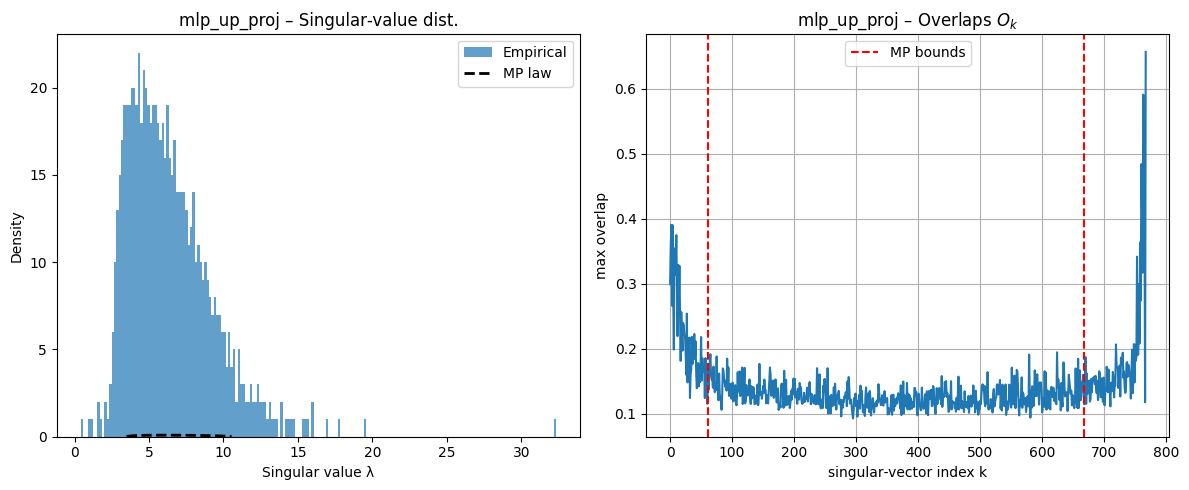

      mlp_down_proj   | W.shape=(3072, 768),  X.shape=(2454, 768)
      top 5 σ(W): [27.617653 17.5305   14.577294 13.227644 12.427411]
      MP bounds: [0.000, 8.094]
      top 5 overlaps: [0.90610881 0.35592436 0.64272268 0.17095913 0.28281816]

      fraction svals~0: 0.000 | # of singular values λ: 768


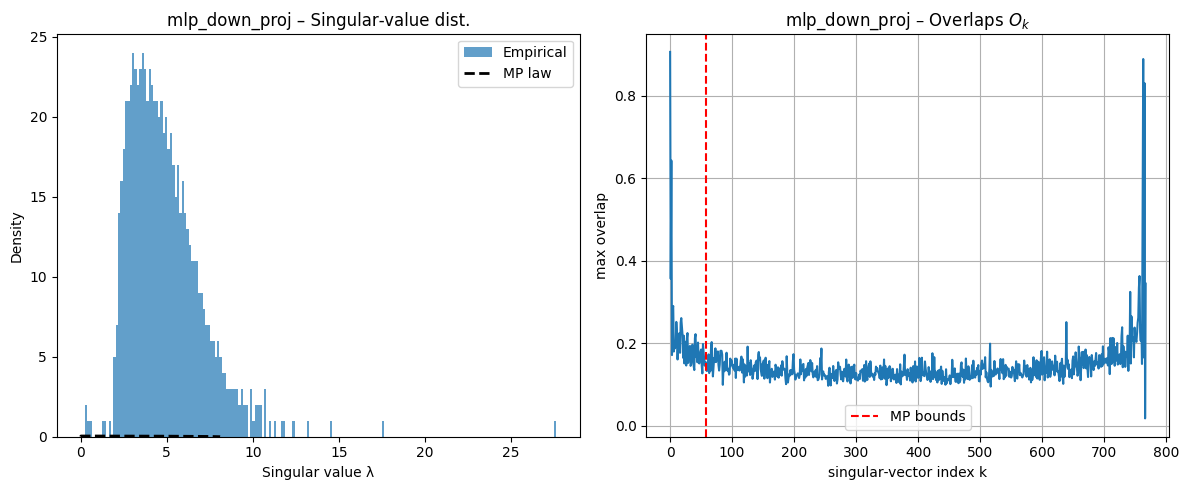


=== Block 6 ===
      attention_proj  | W.shape=(768, 768),  X.shape=(2454, 768)
      top 5 σ(W): [14.976205 10.504531  8.933635  8.683279  8.554008]
      MP bounds: [0.000, 6.301]
      top 5 overlaps: [0.57956264 0.3026984  0.24887444 0.27931268 0.18429706]

      fraction svals~0: 0.042 | # of singular values λ: 768


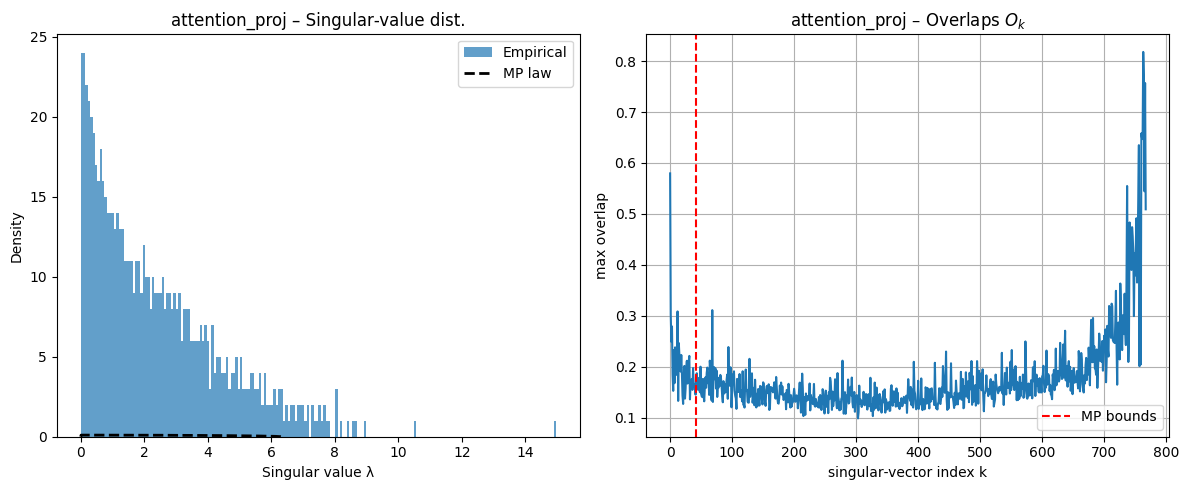

KeyboardInterrupt: 

In [10]:
# For each block & sublayer, slice out the right activations
for block_idx in range(num_blocks):
    print(f"\n=== Block {block_idx} ===")
    # each hook list is length = num_blocks * len(prompts)
    # index formula: prompt_i * num_blocks + block_idx
    def slice_acts(key):
        lst = activations[key]
        # build a (N, seq_len, dim) list
        out = []
        for p_i in range(len(prompts)):
            out.append(lst[p_i * num_blocks + block_idx])
        return torch.cat(out, dim=0)  # (n_prompts*seq_len, D)

    # 3 sub-layers
    sublayers = {
        # "query_proj": {
        #     "W": model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, 0:d],
        #     "X": slice_acts("attn")@model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, 0:d]
        # },
        # "key_proj": {
        #     "W": model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, d:2*d],
        #     "X": slice_acts("attn")@model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, d:2*d]
        # },
        # "value_proj": {
        #     "W": model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, 2*d:3*d],
        #     "X": slice_acts("attn")@model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, 2*d:3*d]
        # },
        # "q_k_interaction": {
        #     "W": model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, 0:d]@model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, d:2*d].T,
        #     "X": slice_acts("attn")@model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, 0:d]@model.transformer.h[block_idx].attn.c_attn.weight.data.cpu().numpy()[:, d:2*d].T
        # },
        "attention_proj": {
            "W":  model.transformer.h[block_idx].attn.c_proj.weight.data.cpu().numpy(),
            "X":  slice_acts("attn.c_proj")              # post-attention (seq_len,d)
        },
        "mlp_up_proj": {
            "W":  model.transformer.h[block_idx].mlp.c_fc.weight.data.cpu().numpy(),
            "X":  slice_acts("mlp.c_fc")          # pre-nonlin (seq_len,4d)
        },
        "mlp_down_proj": {
            "W":  model.transformer.h[block_idx].mlp.c_proj.weight.data.cpu().numpy(),
            "X":  slice_acts("mlp.c_proj")           # post-GELU (4d,seq_len)
        },
    }

    for name, info in sublayers.items():
        W = info["W"]           # shape (m,n)
        X = info["X"]           # torch.Tensor (n_prompts*seq_len, D)
        N, n = X.shape

        # 4) compute covariance F = (X-μ)ᵀ(X-μ)/N  →  (d,d)
        μ = X.mean(dim=0, keepdim=True)
        Xc = X - μ
        F = (Xc.T @ Xc) / N     # torch Tensor (d,d)

        # 5) eigendecompose
        F_cpu = F.detach().cpu().double() 
        eigvals, eigvecs = torch.linalg.eigh(F_cpu)      
        # reorder descending
        eigvals = eigvals.flip(0).cpu().numpy()      # (d,)
        eigvecs = eigvecs.flip(1).cpu().numpy()      # (d,d)

        # 6) SVD of W: W = U Σ Vᵀ, so Vᵀ has shape (m, n)
        #    its rows are the right singular vectors v_kᵀ ∈ Rⁿ
        _, svals, Vt = np.linalg.svd(W, full_matrices=False)

        # 7) overlaps: for each row k in Vt, find max dot with any f_j
        overlaps = np.max(Vt @ eigvecs, axis=1)       # → (m,)

        # 8) Marchenko–Pastur support
        m, n = W.shape
        q = m / n
        σ = np.std(W)*np.sqrt(n)
        lam_min = σ * (1 - np.sqrt(q))
        lam_min = np.where(lam_min < 0, 0, lam_min)
        lam_max = σ * (1 + np.sqrt(q))

        # (a) index boundary for large‐outliers:
        #      find all k where svals_desc[k] > lam_max
        above = np.where(svals > lam_max)[0]
        if above.size:
            # the *last* one is above.max(), 
            # so the first in‐bulk index is above.max()+1
            k_plus = above.max() + 1  
        else:
            k_plus = 0   # no large outliers

        # (b) index boundary for small‐outliers:
        below = np.where(svals < lam_min)[0]
        if below.size:
            # the *first* one below lam_min is below.min()
            k_minus = below.min()
        else:
            k_minus = len(svals)  # no small outliers

        print(f"      {name:15s} | W.shape={(W.shape)},  X.shape={(N,n)}")
        print(f"      top 5 σ(W): {svals[:5]}")
        print(f"      MP bounds: [{lam_min:.3f}, {lam_max:.3f}]")
        print(f"      top 5 overlaps: {overlaps[:5]}\n")
        print(f"      fraction svals~0: {sum(svals<1e-1)/768:.3f} | # of singular values λ: {len(svals)}")

        # MP density
        λ = np.linspace(lam_min, lam_max, 500)
        pdf = (1/(2*np.pi*σ**2*q)) * np.sqrt((lam_min**2-λ**2)*(λ**2-lam_max**2)) / (λ+0.0001)

        # after you have `svals`, _before_ the line‐plot:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)

        # (a) empirical histogram
        counts, bins, _ = plt.hist(svals, bins=200, density=False,
                                alpha=0.7, label='Empirical')
        plt.plot(λ, pdf, 'k--', linewidth=2, label='MP law')
        plt.xlabel('Singular value λ')
        plt.ylabel('Density')
        plt.title(f'{name} – Singular‐value dist.')
        plt.legend()

        # (c) overlaps on the right
        plt.subplot(1,2,2)
        plt.plot(overlaps)
        plt.axvline(k_plus, color='r', linestyle='--', label='MP bounds')
        if lam_min>0: plt.axvline(k_minus, color='r', linestyle='--')
        plt.title(f'{name} – Overlaps $O_k$')
        plt.xlabel('singular‐vector index k')
        plt.ylabel('max overlap')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

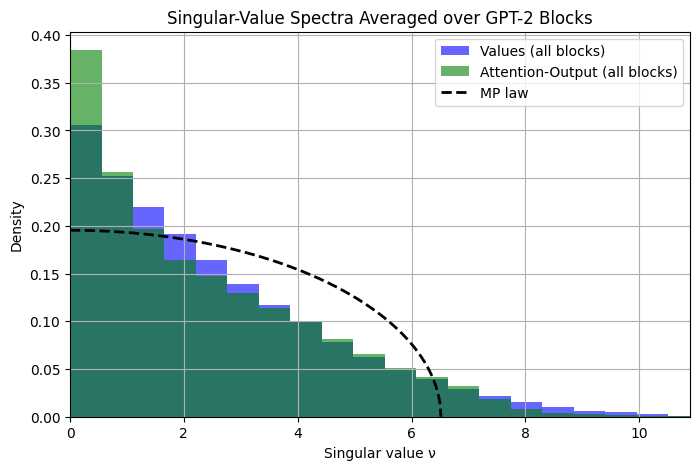

In [31]:
d = model.config.hidden_size
num_blocks = len(model.transformer.h)

# 1) collect all singular values
sv_Q = []
sv_K = []
sv_V = []
sv_O = []

for layer in range(num_blocks):
    block = model.transformer.h[layer]
    # stacked c_attn: weight shape (3d, d), split into Q, K, V
    W_c_attn = block.attn.c_attn.weight.data.cpu().numpy()  # (3d, d)
    WQ = W_c_attn[:, 0:d]                                   # Query projection (d,d)
    WO = block.attn.c_proj.weight.data.cpu().numpy()       # Attention-Output (d,d)
    WK = W_c_attn[:, d:2*d]
    WV = W_c_attn[:, 2*d:3*d]

    # singular values
    sQ = np.linalg.svd(WQ, compute_uv=False)
    sK = np.linalg.svd(WK, compute_uv=False)
    sV = np.linalg.svd(WV, compute_uv=False)
    sO = np.linalg.svd(WO, compute_uv=False)

    sv_Q.append(sQ)
    sv_K.append(sK)
    sv_V.append(sV)
    sv_O.append(sO)

# flatten into single vectors
all_sQ = np.hstack(sv_Q)  # shape (num_blocks * d,)
all_sK = np.hstack(sv_K)
all_sV = np.hstack(sv_V)
all_sO = np.hstack(sv_O)

# 2) estimate MP parameters from the empirical variance of WQ entries
#    here m=n=d, so q=1, sigma^2 = var(WQ)
all_W = np.vstack([model.transformer.h[layer].attn.c_attn.weight.data.cpu().numpy()[:, 2*d:3*d]
                    for layer in range(num_blocks)])
sigma2 = all_W.var()
m, n = d, d
q = m / n
sigma_tilde = np.sqrt(sigma2) * np.sqrt(n)
nu_minus = sigma_tilde * (1 - np.sqrt(m/n))
nu_plus  = sigma_tilde * (1 + np.sqrt(m/n))

# grid for MP density
nu = np.linspace(max(nu_minus, 1e-6), nu_plus, 500)
prefac = (n/m) / (np.pi * sigma_tilde**2 * nu)
mp_pdf = prefac * np.sqrt((nu_plus**2 - nu**2) * (nu**2 - nu_minus**2))

# 3) plot
plt.figure(figsize=(8, 5))
bins = np.linspace(0, max(all_sQ.max(), all_sO.max()), 100)

# plt.hist(all_sQ, bins=bins, density=True,
#          alpha=0.6, color='blue',  label='Query (all blocks)')
# plt.hist(all_sK, bins=bins, density=True,
#          alpha=0.6, color='red',  label='Keys (all blocks)')
plt.hist(all_sV, bins=bins, density=True,
          alpha=0.6, color='blue',  label='Values (all blocks)')
plt.hist(all_sO, bins=bins, density=True,
          alpha=0.6, color='green',label='Attention-Output (all blocks)')

plt.plot(nu, mp_pdf, 'k--', linewidth=2, label='MP law')

plt.title('Singular-Value Spectra Averaged over GPT-2 Blocks')
plt.xlabel('Singular value ν')
plt.ylabel('Density')
plt.xlim(0, max(all_sV))
plt.legend()
plt.grid(True)
plt.show()